<table style="background-color:#F5F5F5;" width="100%">
<tr><td style="background-color:#F5F5F5;"><img src="../images/logo.png" width="150" align='right'/></td></tr>     <tr><td>
            <h2><center>Aprendizagem Automática em Engenharia Biomédica</center></h2>
            <h3><center>1st Semester - 2025/2026</center></h3>
            <h4><center>Universidade Nova de Lisboa - Faculdade de Ciências e Tecnologia</center></h4>
</td></tr>
    <tr><td><h2><b><center>Lab 6 - Decision Trees and Feature Extraction</center></b></h2>
    <h4><i><b><center>Human Activity Recognition with Decision Trees</center></b></i></h4></td></tr>
</table>

## 1. Human Activity Recognition and Timeseries Data

### 1.1 Human Activity Recognition
Human Activity Recognition (HAR) is a growing field in machine learning where the goal is to classify physical activities based on data from inertal sensors (such as accelerometers, gyroscopes, magnetometers), video (RGB, depth or thermal cameras), audio (microphones), among others. Data collected from these sensors can be used to infer activities like walking, running, sitting, and more.

HAR has a wide range of applications, such as:
* __Healthcare__: monitoring patient activity and rehabilitation progress
* __Fitness__: tracking exercise routines
* __Smart Homes__: detecting daily activities for automation

Since such activities change continuously, it is necessary to consider data collected throughout time, so one can predict the performed activity at any given moment.

### 1.2 Timeseries Data
Sensor data for HAR is inherently timeseries data, meaning that the data points are collected over time. This creates a sequence where each data point depends on the ones that precede it. Activities are continuous by nature, so understanding the temporal patterns is key to accurate recognition. For example, walking involves a repetitive cycle that can be detected by analyzing sequences of accelerometer readings.

Describing it in mathematical terms, a timeseries is a sequence of data points indexed in time order:

$$ \{x_1, x_2, ..., x_n\} $$

where:

* $n \in \mathbb{N}$ is the number of observations
* $x_i$ is the observation at time $t_i$ for $i \in \{1, ..., n\}$
* $t_1 < t_2 <...<t_n$ represents the sequence of time points, with $t_i$ typically spaced at regular intervals.

Each $x_i$ can be a scalar (single value) or a vector, depending on the number of variables being measured at each time point. The image below shows a discrete timeseries.

<div style="text-align:center;">
    <img src="https://raw.githubusercontent.com/hgamboa/nova-aaeb/refs/heads/main/images/timeseries.png" width="600">
</div>


Working with timeseries data introduces unique challenges, such as:

* __Sequential Dependency__: unlike traditional datasets where each sample is independent, timeseries data has an inherent temporal dependency between consecutive data points.
* __High Dimensionality__: timeseries data can be very high-dimensional, especially when collected from multiple sensors over a long period.
* __Windowing and Segmentation__: in order to convert continuous sensor streams into manageable data chunks for machine learning models, we need techniques like windowing.

### 1.3 Goal of Today's Class
In today's practical session, you will learn how to __develop Decision Tree Models for HAR__ by:

* Using the UCI Human Activity Recognition Dataset.
* Pre-processing (data preparation of) timeseries data by windowing it.
* Extract features from the windowed data.
* Train and evaluate Decision Trees.

## 2.The UCI Human Activity Recognition Using Smartphones Dataset

In today's class we are going to utlize a widely-used dataset for HAR: the [__UCI Human Activity Recognition Using Smartphones Dataset__](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones):

The UCI Human Activity Recognition Using Smartphones Dataset was collected from __30 participants__ (ageed between 19 and 48 years old) performing __six different activities__ while wearing a __smartphone on their waist__. The smartphone recorded data from its embedded accelerometer and gyroscope sensors at a constant rate of __50Hz__, capturing __three-dimensional linear acceleration and angular velocity__.

The performed activites and their corresponding label are:

| Activity             | Label  |
|----------------------|--------|
| Walking              | 1      |
| Walking upstairs     | 2      |
| Walking downstairs   | 3      |
| Sitting              | 4      |
| Standing             | 5      |
| Laying               | 6      |


The dataset is already dvidied into __train__ and __test__ sets. These are setup as follows:
1. __Training Set__: 70% of the participants used for model training (a total of 21 pariticpants).
2. __Test Set__: 30% of the participants used for model evaluation (a total of 9 participants).

In this notebook, __we are only going to use the x-axis of the raw acceleration data__.

### 2.1 Downloading the Dataset

the code below will download the dataset into your project.

_Note_: you might have to install the [__wget__](https://pypi.org/project/wget/) package in order to perfrom the dataset install.

In [1]:
# imports needed for the Notebook
# %matplotlib notebook
# !pip install wget
import os
import wget
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Tuple, List, Union

In [2]:
# -- Download dataset from UCI repo -- #

# check if dataset was already downloaded before
if not os.path.exists("Data/UCI HAR Dataset.zip"):

    # define the url where the .zip file of the dataset is stored
    url = 'https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip'

    # download the dataset
    wget.download(url, out="Data/UCI HAR Dataset_outer.zip")

# check if the outer zip file still exists (just in case that this code is run multiple times)
if os.path.exists("Data/UCI HAR Dataset_outer.zip"):
    # Unzip the outer folder
    with zipfile.ZipFile("Data/UCI HAR Dataset_outer.zip", 'r') as outer_zip:
        outer_zip.extractall("Data")

    # remove the original zipfile and unnecessary files
    os.remove("Data/UCI HAR Dataset_outer.zip")
    os.remove("Data/UCI HAR Dataset.names")

# unzip the actual dataset
with zipfile.ZipFile("Data/UCI HAR Dataset.zip", 'r') as data_zip:
    data_zip.extractall("Data")

### 2.2 Getting an Understanding of the Structure of the Dataset

The dataset that we downloaded contains several folders and files. As we are going to focus only the x-axis of the raw acceleration data, we will only need the following files and folders (all other files and folder can be ignored):

* __activity_labels.txt__ (file): This file contains the labels for the performed activities.
* __train__ (folder): This folder contains the data for training.
* __test__ (folder): This folder contains the data for testing.

Inside of the train and test folders we need the following files/folder:

* __subject_train.txt__ (file): contains the IDs of the subjects used in the training set.
* __subject_test.txt__ (file): contains the IDs of the subjects used in the testing set.
* __y_train.txt__ (file): contains the activity labels corresponding to the sensor data used in the training set.
* __y_test.txt__ (file): contains the activity labels corresponding to the sensor data for the testing data.
* __Inertial Signals__ (folder): this folder contains the raw sensor files.

Within the Inertial Signals folder, the only files that are relevant are:

* __total_acc_x_train.txt__ (file): contains the raw accelerometer data of __all subjects used in the training set__.
* __total_acc_x_test.txt__ (file): contains the raw accelerometer data of __all subjects used in the testing set__.

### 2.3 Getting an Understanding of how the files correspond to each other

To understand how all these files correspond to each other it first of all important to understand how the files containing the raw accelerometer data (total_acc_x_train.txt and total_acc_x_test.txt) are organized.

The shape of both files is:
* __total_acc_x_train.txt__: [7352, 128] (rows: 7352, columns: 128)
* __total_acc_x_train.txt__: [2957, 128]

Now you might wonder why the files have these shapes. The reason is that researchers who published this dataset, use a particular way to store the data. They divided the signals for each subject in to chunks (windows) containig 128 samples of data and then stored these data windows in each row of the dataset. __These windows overlap by 50%__, meaning that each row — except for the first — contains data that is 50% repeated from the previous window (see image below).

With regrads to the other files they have the following shapes:
* __subject_train.txt__: [7352, 1]
* __subject_test.txt__: [2957, 1]
* __y_train.txt__: [7352, 1]
* __y_test.txt__: [2957, 1]

This means, that for each row contained in the raw accelerometer data files we have the corresponding subject ID (subject_train) and and performed activity label (y_train). The correspondence between the files is visualized in the image below for the training data.

<div style="text-align:center;">
    <img src="https://raw.githubusercontent.com/hgamboa/nova-aaeb/refs/heads/main/images/UCI-Dataset.png" width="800">
</div>

### 2.4 Loading the data

As described above, we will __only use the raw x-axis of the accelerometer sensor__. For your convenience we have already written a function that loads the data for you. The method, defined below performs the loading of one acceleration axis, including the original raw data and the corresponding labels. Furthermore, the ID of the subject that performed the activity is also loaded.

_Note_: To obtain the orginal data without overlap we __load half (64) of the samples contained in each row and then stack the data horizontally__ using [numpy.hstack()](https://numpy.org/doc/stable/reference/generated/numpy.hstack.html). The horizontal stack is equivalent to concatenating the data horizontally.

_Note_: In the function we are adjusting the labels and subject IDs so that we have a label and a subject ID for each data sample/time instance.

In [3]:
def get_inertial_data(acc_axis: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Loads and processes the inertial signal data from the UCI Human Activity Recognition (HAR) dataset.

    This function reads accelerometer data for a specified axis (e.g., 'x', 'y', or 'z') for both 
    the training and test datasets. It also loads corresponding activity labels and subject IDs. 
    The data is windowed and repeated 64 times to match the window size.

    :param acc_axis: The axis of accelerometer data to load ('x', 'y', or 'z').

    :returns: 
        - X_train: Training set accelerometer data (horizontally stacked).
        - y_train: Repeated activity labels for the training set.
        - subject_train: Repeated subject IDs for the training set.
        - X_test: Test set accelerometer data (windowed and stacked horizontally).
        - y_test: Repeated activity labels for the test set.
        - subject_test: Repeated subject IDs for the test set.
        - activity_labels: Array of activity labels for both training and test sets.

    :rtype: Tuple of NumPy arrays containing processed data.
    """
    # --- loading training data --- #
    # Load training accelerometer data for the specified axis
    X_train = np.loadtxt('Data/UCI HAR Dataset/train/Inertial Signals/total_{}_train.txt'.format(acc_axis))

    # stack all data horizontally to obtain a 1D array
    X_train = np.hstack([window[:64] for window in X_train])
    
    # Load activity labels for training data
    y_train = np.loadtxt('Data/UCI HAR Dataset/train/y_train.txt', dtype=int)

    # repeat 64 times to have a label for each training data sample
    y_train = np.repeat(y_train, 64)
    
    # Load subject IDs for training data
    subject_train = np.loadtxt('Data/UCI HAR Dataset/train/subject_train.txt', dtype=int)

    # repeat 64 times to have a subject ID for each training data sample
    subject_train = np.repeat(subject_train, 64)

    # --- loading testing data --- #
    # Load test accelerometer data for the specified axis
    X_test = np.loadtxt('Data/UCI HAR Dataset/test/Inertial Signals/total_{}_test.txt'.format(acc_axis))

    # stack all data horizontally to obtain a 1D array
    X_test = np.hstack([window[:64] for window in X_test])
    
    # Load activity labels for test data
    y_test = np.loadtxt('Data/UCI HAR Dataset/test/y_test.txt', dtype=int)

    # repeat 64 times to have a label for each testing data sample
    y_test = np.repeat(y_test, 64)
    
    # Load subject IDs for test data
    subject_test = np.loadtxt('Data/UCI HAR Dataset/test/subject_test.txt', dtype=int)

    # repeat 64 times to have a subject ID for each training data sample
    subject_test = np.repeat(subject_test, 64)
    
    # Load activity labels (activity number and corresponding activity name)
    activity_labels = pd.read_csv('Data/UCI HAR Dataset/activity_labels.txt', 
                                  index_col=0, header=None, sep=' ')
    
    # Return all the processed data
    return (X_train, y_train, subject_train, X_test, y_test, subject_test, np.hstack(activity_labels.values))

Let's load the data using the defined function and make some prints to see how many data samples we have for training and testing

In [4]:
# load the data
train_data, train_labels, subject_train, test_data, test_labels, subject_test, activity_labels = get_inertial_data('acc_x')

# print out some information on the loaded data
print("ACC train data shape: {} | target shape: {} | Subjects: {}".format(train_data.shape, train_labels.shape, np.unique(subject_train).size))
print("ACC test  data shape: {} | target shape: {} | Subjects: {}".format(test_data.shape, test_labels.shape, np.unique(subject_test).size))
print("\nAvailable Activities:\n{}".format(activity_labels))

ACC train data shape: (470528,) | target shape: (470528,) | Subjects: 21
ACC test  data shape: (188608,) | target shape: (188608,) | Subjects: 9

Available Activities:
['WALKING' 'WALKING_UPSTAIRS' 'WALKING_DOWNSTAIRS' 'SITTING' 'STANDING'
 'LAYING']


The image below shows how the _get_inertial_data()_ function retrieves the data from the UCI dataset and how it is organized in the end.

_Note_: The image is not to the correct scale. As it is hard to visualize each sample for a timeseries collected at 50 Hz, the image does not 100 % reflect reality. __In reality there exists a value for subject_train and y_train for each sample of X_train (i.e., for each time instance $t_i$ there is a triplet of values)__:

<div style="text-align:center;">
    <img src="https://raw.githubusercontent.com/hgamboa/nova-aaeb/refs/heads/main/images/HAR_dataset_organized.png" width="800">
</div>

#### 2.4.1 Visualizing the Data From One Subject

Now that we loaded the data, we can visualize the data from one subject. The code below generates a plot of the accelerometer data and adds vertical lines at the transitons between the activities. We will plot the data of __subject 1__. 

the activity labels for the recording shown below are: 
['STANDING' 'SITTING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS' 'STANDING' 'SITTING' 'LAYING' 'SITTING' 'LAYING'
 'WALKING' 'WALKING_DOWNSTAIRS' 'WALKING_UPSTAIRS' 'WALKING_DOWNSTAIRS']


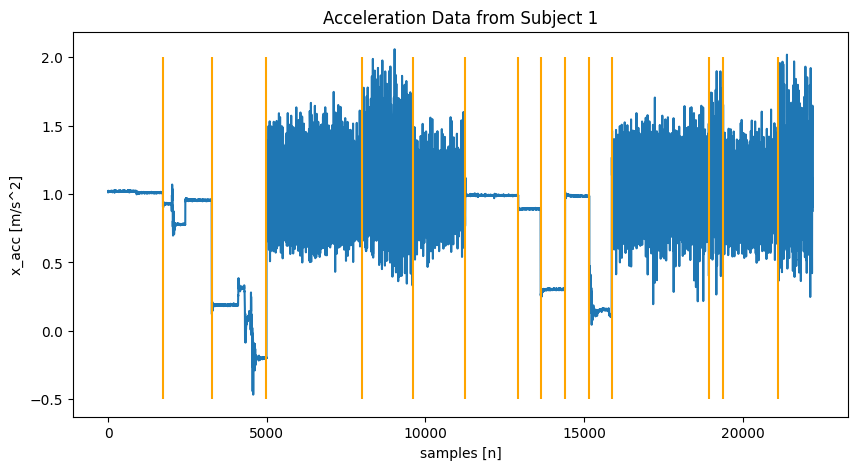

In [5]:
# define the subject
subject = 1

# get the positions within the subject_train array that are equal to the subject
# this creates a boolean array that can be used to index the train data
pos_subject_1 = subject_train == subject

# get the signal data that corresponds to subject 1
signal_subject_1 = train_data[pos_subject_1]

# get the labels that correspond to subject 1
y_subject_1 = train_labels[pos_subject_1]

# calculate the sequantial difference between the labels
# this will show us where the transitions between activities are
# example np.diff([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]) | result: [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
activity_transitions = np.diff(y_subject_1)

# get the indices of the transitions by checking where in the array there are values that are != 1
idx_transitions = np.where(activity_transitions)[0]

# get the target labels at the transition points
y_transition = y_subject_1[idx_transitions]

# insert the label at the end of the recording
y_transition = np.append(y_transition, y_subject_1[-1])

# get the corresponding activity labels (the string version) at the transition points 
transition_activity_labels = activity_labels[y_transition-1]

# print the activity labels to see which activity was performed at what time
print("the activity labels for the recording shown below are: \n{}".format(transition_activity_labels))


# plot the data 
plt.figure(figsize=(10, 5))

plt.plot(signal_subject_1) # plot the signal
plt.vlines(idx_transitions , -.5, 2, color='orange') # plot the transition lines

# add titles and labels
plt.title("Acceleration Data from Subject {}".format(subject))
plt.xlabel('samples [n]')
plt.ylabel('x_acc [m/s^2]')
plt.show()

#### 2.4.2 Checking the Distribution of Classes Within the Dataset

As always, it is important to verify whether the dataset is balanced, as having class imbalance leads to suboptimal results. The code below plots the distrubtion of classes by visualizing the amount of data points we have for each activity class.

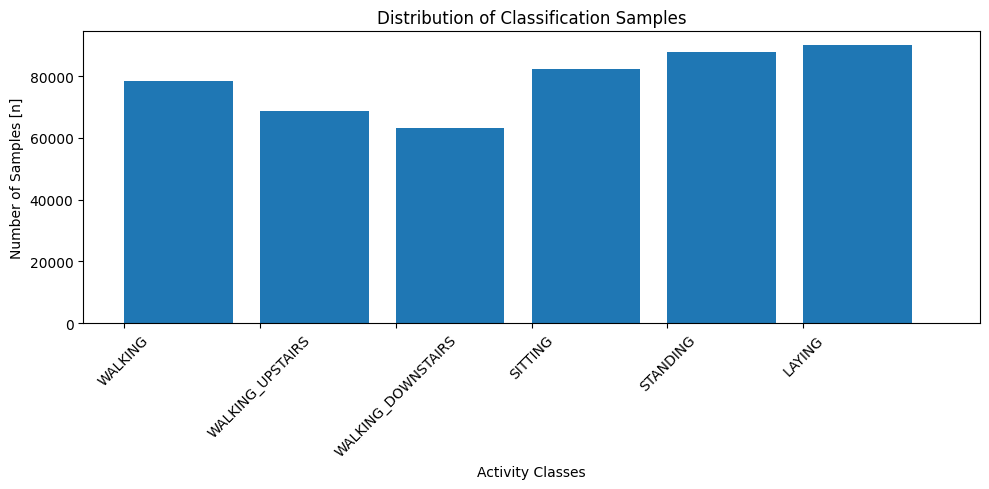

In [6]:
# plot the data
plt.figure(figsize=(10, 5))
plt.hist(train_labels, range=[1,7], bins=6, width=0.8)
plt.xticks(np.arange(1,7), activity_labels, rotation=45)

# add titles and labels
plt.title("Distribution of Classification Samples")
plt.xlabel("Activity Classes")
plt.ylabel("Number of Samples [n]")
plt.tight_layout()

## 3. Signal Windowing and Feature Extraction

Time-series data, such as sensor data from accelerometers or gyroscopes, consists of continuous sequences of observations over time. Machine learning models, however, often expect fixed-size, independent samples. To make time-series data usable for such models, we need to transform these continuous sequences into shorter, fixed-length segments known as __windows__ to then later perform __feature extraction__ on these.

The extracted features from each window are then the input to the model. Thorugh this process we can thus effectively, turn timeseries data into the usual format that is used to train machine learning models, where we have a vector of features for each instance we want to classify.

The image below shows this process considering windowing without overlap.

<div style="text-align:center;">
    <img src="https://raw.githubusercontent.com/hgamboa/nova-aaeb/refs/heads/main/images/windowing_and_feature_extraction.png" width="600">
</div>

### 3.1 Signal Windowing

Windowing is essential because:

* It allows us to capture patterns and information within smaller time segments, improving the model's ability to identify meaningful features.
* By segmenting data into fixed-length windows, we standardize input shapes for model training.
* Windowing also helps address challenges related to long dependencies and computational efficiency.

In the HAR dataset, each activity is recorded over time, and dividing this into smaller, fixed windows allows models to learn patterns associated with specific actions over short intervals, e.g., walking or standing

There exist two commonly used techniques for timeseries windowing. These are:

1. __Non-overlapping Windows__:
* Each window contains a fixed number of observations without overlap with adjacent windows.
* This method is efficient but might miss transitions occurring at window boundaries.

2. __Overlapping Winows__:
* Overlapping windows allow each window to partially overlap with the previous one, often by a fixed number of time steps.
* Overlapping helps retain information near the boundaries and may improve classification by increasing data availability, but it requires more computation
* This technique also allows for increasing the data that is used for training and testing, thus it is particularly useful when there are less recordings.

### 3.2 Choosing the Window Size
Now one question remais: __how do we decide the size/length of our window?__

Selecting the window size is crucial in time-series analysis as it influences the model's ability to capture relevant patterns in the data. Here are key factors to consider when deciding on an appropriate window size:

1. __Nature of the Activity or Pattern__:
* Shorter windows capture fine-grained details but may not include enough context for certain activities.
*  Longer windows encompass more context, which is beneficial for identifying longer activities but may dilute short, transient patterns.
* For human activity recognition (HAR), studies often use window sizes between 1 and 5 seconds, depending on the activity's complexity and variability.

2. __Sampling Frequency__:
* The dataset’s sampling rate (e.g., 50 Hz) influences how many observations fit into each window.
* For instance, at 50 Hz, a 2-second window would contain $50 \times 2 = 100$ time steps, whereas a 4-second window would contain 200.

3. __Trade-off Between Model Performance and Efficiency__:

* Larger windows produce fewer samples, which can improve computational efficiency but may reduce training data diversity.
* Smaller windows yield more samples, which can improve performance but increase computational costs.

4. __Overlapping and Boundary Conditions__:

* Window size should balance well with stride length to capture boundary information, especially for activities that might transition near the edges of windows.

As you can see, there is no standard way to define the window size. Thus you should always:
>__Experiment with several window sizes and evaluate model performance to identify the optimal choice for a particular task.__

__Exercise 3.1__: 

Now that we have the basics covered, you will now implement a function that performs the windowing of the signal. For simplicty you will implement a __non-overlapping__ windowing scheme. You will use a __window size = 5 seconds__. 

Given that the data is now in a continuous format, you need to be careful whether your extracted window contains only data from a unique activity. Mixing data from different activities into your window will introduce noise into your training dataset. Thus, you need to find a strategy to avoid this.

__Tasks__:

* Implement a function the performs a non-overlapping windowing of the data for both X and y.
* The function should be called: __window_splitter__.
* The function should have the following parameters:
    >* __acc__: timeseries acceleration data of shape (n_samples,) | Type: np.ndarray
    >* __labels__: array of labels corresponding to each time step in acc, with shape (n_samples,) | Type: np.ndarray
    >* __window_size__: desired window length in seconds. | Type: int
    >* __fs__: the sampling frequency. | Type: int
* The function should output:
    >* __X_windows__: list containing the extracted windows. The list is of shape (number_of_windows, samples_per_window)
    >* __y_windows__: list of labels assigned to each window. The list is of shape (number_of_windows)

__Hints__:

* Given that the window is given in seconds, you will have to calculate how many data samples fit into that window. This will make windowing the data a lot easier. YOu can calculate the number of samples that fit into a window using the following formula: $w_{samples} = w_{seconds} * f_s$.
* The start index (i.e., the position where the last window starts) is: $index_{last window} = len(acc) - w_{samples} + 1$.
* You can use the [range()](https://pythonbasics.org/range-function/) function to create a range object containing the all start indices of the windows. You can use this range object within a for-loop to cycle over it.

__Exercise 3.2__: 

Now that the signal is windowed, it is time to extract features from each window. Again, to simplify you will only extract the following statistical features: 
* the __mean__ value of the window.
* the __maximum__ value of the window.
* the __minimum__ value of the window.

__Tasks__:

* Implement a function to calculate statistical features from the extracted windows.
* The function should be called: __compute_statistical_features__.
* The function should have the following parameter:
    >* X_windows: list containing the extracted windows containing the accelerometer data. The list is of shape (number_of_windows, samples_per_window) | Type: List or np.ndarry
* The functions should output:
    >* statistical_features: A 2D array of shape (n_windows, 3), where each row contains the mean, max, and min of each window. | Type: list

__Hints__:
* You can use the functions [__numpy.mean()__](https://numpy.org/doc/stable/reference/generated/numpy.mean.html), [__numpy.min()__](https://numpy.org/doc/stable//reference/generated/numpy.min.html), and [__numpy.max()__](https://numpy.org/doc/stable//reference/generated/numpy.max.html). When you set a certain parameter, i.e., calculate along a certain dimension you can write the code without a for-loop.
* The function [__numpy.column_stack()__](https://numpy.org/doc/stable/reference/generated/numpy.column_stack.html) can help you in organizing your output into and array of shape (n_windows, 3).

__Exercise: 3.3__: 

Now that you have written the functions for windowing the data and extract features from the windows, it is time to apply your functions to the data we loaded in section 2.4.

__Tasks__:

* Define the sampling frequency and the window size as constants. ($f_s = 50Hz$, $w_{seconds} = 5s$)
* Use the developed functions to window the data and extract the features, for both the training and testing data.
* Print the first 10 rows of training data after computing the statistical features to check whether your output is correct.

## 4. Decision Tree Classifier

### 4.1 Decision Tree Basics
Decision Tree is one of the most widely used ML algorithms. In this method, the learning function that maps a set of variables into the target is represented by a decision tree. Such trees can also be represented as sets of if-then rules for human readability. Decision trees have the power to map highly non-linear data.

<div style="text-align:center;">
    <img src="https://raw.githubusercontent.com/hgamboa/nova-aaeb/refs/heads/main/images/decision_tree.png" width="600">
</div>

When looking at a decision tree, there are some important concepts to take into consideration:

* __Root node__: The top node of a decision tree from which all node splits come from. It represents the entire population.

* __Decision nodes__: These are nodes which are subdivided into new branches. Similarly, __parent nodes__ are those divided into sub-nodes, and these are called the __child nodes__.

* __Leaf or Terminal nodes__: Includes all nodes that are not further subdivided, thus representing the predicted class.

Decision Trees therefore classify samples by sorting them down from the root of the tree up to some leaf node, providing the final classification. Each node evaluates a specific attribute, which then divides the samples according to an optimized condition.

These models were originally developed for classification, although variations exist for the regression task. By dividing the multidimensional space into sections, these models are quite robust to outliers.

### 4.2 Optimizing Decision Trees

Training a decision tree is an iterative process towards an optimized solution. In simple terms, at each iteration, every data feature is tested to assert which is the most useful to classify the examples.

At every decision node, all features are tested, to select how the new branches will be created. The training continues using the training examples associated with each child node. The algorithm converges when no more samples are left to split, or when some stopping criteria is met.

##### 4.2.1 Entropy

One of the most common concepts related to the selection of decision features is _Entropy_. This measure characterizes the impurity of an arbitrary collection of examples, namely the set of samples available in some node. 

Entropy thus describes the purity of a node. The lower the value of entropy, the higher the node's purity. An homogeneous node has an entropy of 0. Therefore, the training process will create new subdivisions to lower the impurity of the system.

The entropy of a set of samples can be computed by the following equation:

$$ \text{Entropy} = - \sum_{i=1}{p_i . \log_2{p_i}} $$

where $p_i$ is the probability of each class $i$ within the samples of the decision node. Entropy will be 1 when dealing with a binary classification problem the training set contains an equal proportion of both values, i.e. $p_i=0.5$. If all examples are from the same class, then the entropy will be 0.

The training process that uses entropy as a splitting strategy is called __Information Gain__, which is determined by:

$$ \text{Information Gain} = 1 - \text{Entropy}$$

The variable selection process will then exhaustively test the Information Gain brought by each feature.

##### 4.2.2 Gini Impurity

Another strategy often used is the Gini Impurity, which leverages the Gini concept. It translates the probability of correctly labeling a randomly chosen element if it was randomly labeled according to the distribution of labels in the node. It can be determined by:

$$ \text{Gini} = \sum_{i=1}{p_i^2} $$

Therefore, the Gini Impurity is determined by:

$$ \text{Gini Impurity} = 1 - \text{Gini}$$

### 3.3 Training Decision Trees in Scikit-learn

Using scikit-klearn package training a Decision Tree is straight forward as the package provides a class that performs the necessary tasks:

* [__DecisionTreeClassifier()__](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

The hyperparameters of the Decision Tree can be set during the intialization of the class. The code below uses the Decision Tree with its default paramaters.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# initialize the decsision tree model using default paramaters
clf = DecisionTreeClassifier(random_state=42)

__Exercise 4.1:__ It is time to train and evaluate the decisison tree model. This will be your next task.

__Tasks__:
* Train the classifier
* Check its performance using accuracy for both train and test sets.
* What can you observe for the training and testing accuracy?

__Write your answer here__: double click to edit the cell

### 3.3 Visualizing the Trained Decision Tree

Scikit-learn also provides the option to visualize the trained Decision Tree. This allows us to undertsand the decision boundaries for each decision the Decision Tree made, which makes this model easy interpretable.

To visualize the Decision Tree, we can use the function:
* [__plot_tree()__](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html)

In [ ]:
from sklearn.tree import plot_tree

# create a figure
plt.figure(figsize=(18,10))

# plot the decision tree
plot_tree(clf, filled=True)
plt.show()

### 3.4 Avoiding Overfitting in Decision Trees

As we saw from the code above, the trained Decision Tree overfit to the training data. When using a Decision Tree with the default parameters, the tree will always perfectly fit to the data. This is inherent to decisision tree as any amount of data points can be perfectly separated using a complex form of if-else blocks.

To avoid overfitting it is necessary to set the __hyperparameters__ of the tree. This process is generally called __hyperparameter tuning__ and in the particular case of Decision Trees it is also referred to as __pruning__. As it is not possible to test all combinations by hand, it is useful to resort to additional optimization techniques (we will learn about optimization techniques in the next lab class).

The DecisionTreeClassifier has the following hyperparameters in scikit_learn:

| Hyperparameter             | Type & Default                        | Description |
|----------------------------|---------------------------------------|-------------|
| __criterion__                | _str_, default=`"gini"`              | The function used to measure the quality of a split. Options are `"gini"` (Gini impurity) and `"entropy"` (information gain). |
| __splitter__                 | _str_, default=`"best"`              | Strategy to choose the split at each node. `"best"` chooses the best split, "random"` chooses a random split. |
| __max_depth__                | _int_, default=`None`                | The maximum depth of the tree. Limits depth to prevent overfitting. If `None`, nodes expand until all leaves are pure or contain fewer than __min_samples_split__ samples. |
| __min_samples_split__        | _int_ or `float`, default=`2`        | Minimum number of samples required to split an internal node. If `float`, it represents a percentage of the total samples. |
| __min_samples_leaf__         | _int_ or `float`, default=`1`        | Minimum number of samples required to be at a leaf node. Helps avoid leaf nodes with very few samples. |
| __min_weight_fraction_leaf__ | _float_, default=`0.0`               | Minimum weighted fraction of samples required to be at a leaf node, helpful with sample weights to balance uneven data. |
| __max_features__             | _int_, _float_, _str_, or `None`, default=`None` | Number of features to consider when looking for the best split. If `int`, exact number; if `float`, fraction of total features; if `"auto"`, `"sqrt"`, or `"log2"`, uses square root or log base 2 of features. |
| __max_leaf_nodes__           | _int_, default=`None`                | Limits number of leaf nodes to control model complexity and prevent overfitting. |
| __min_impurity_decrease__    | _float_, default=`0.0`               | Splits only if impurity decrease is greater than or equal to this value, aiding in pruning. |
| __class_weight__             | _dict_, _list of dicts_, `"balanced"`, or `None`, default=`None` | Adjusts weight of each class for imbalanced data. `"balanced"` adjusts weights inversely to class frequencies. |
| __ccp_alpha__                | _float_, default=`0.0`               | Complexity parameter for **Minimal Cost-Complexity Pruning**. Higher values prune more tree branches by penalizing complexity. |

__Exercise 3.2__: 

Let's now train a tree that avoids overfitting to the data by pruning it. For simplicity you will only set one hyperparameter: __max_depth__

__Tasks__:
* Train a new DecisionTreeClassifier model
* Set __max_depth = 5__
* Check its performance using accuracy for both train and test sets.
* Plot the trained tree

__Exercise 3.4:__ 

To get an understanding how our model performs on the different classes, it is useful to look at the confusion matrix

__Tasks__:
* Plot the confusion matrix to understand the misclassifications of our model.

__Hint__:
* As you have learned before you can use [__CofnsuionMatrixDisplay.from_predicitons()__](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) for visualization.

## 4. Automatic Feature Extraction with TSFEL

Another method to extract useful information from data is to leverage automatic feature extraction tools, which can compute in an efficient way more informative representations of our data.

For time series data, the Time Series Feature Extraction Library ([TSFEL](https://tsfel.readthedocs.io/en/latest/)) is able to extract features from the temporal, statistical and spectral domains. 

We will try this tool in the Human Activity Recognition Dataset, but first we need to install it. Run on your terminal:

`pip install tsfel`

Let's see how it works. The computation process takes some time, TSFEL will extract 259 features. 

In [ ]:
import tsfel

# get all features available in tsfel
cfg = tsfel.get_features_by_domain()

# extract features for the training and testing data
X_train_tsfel = tsfel.time_series_features_extractor(cfg, train_windows, fs=50)
X_test_tsfel = tsfel.time_series_features_extractor(cfg, test_windows, fs=50)

In [ ]:
X_train_tsfel.head()

__Excercise 4.1__: 

Final exercise! Given the new feature sets, you have to train a new DecisionTreeClassifier and evaluate its performance.

__Tasks__:

* Train a new DecisionTreeClassifier model
* Set __max_depth = 5__
* Check its performance using accuracy for both train and test sets.

Adding more features increase our accuracy! But now we have __250__ features instead of __3__. 

With this high number of features we can apply __feature selection methods__ and increase again our accuracy. In the next lab we will learn about how to implement these methods.